In [1]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import v2 as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def plot_image(tensor):
    plt.figure(figsize=(1.25, 1.25))
    plt.axis('off')
    plt.imshow(tensor.permute(1, 2, 0).numpy())

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 3, kernel_size=3, padding=1)

        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.bnorm1(x)

        x = self.lrelu(self.conv2(x))
        x = self.bnorm2(x)

        x = self.lrelu(self.conv3(x))
        x = self.bnorm3(x)
        
        x = self.tanh(self.conv4(x))
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.bnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 16, kernel_size=5)
        self.bnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 8, kernel_size=5)
        self.bnorm3 = nn.BatchNorm2d(8)

        self.conv4 = nn.Conv2d(8, 4, kernel_size=5)
        self.bnorm4 = nn.BatchNorm2d(4)

        self.conv5 = nn.Conv2d(4, 2, kernel_size=5)
        self.bnorm5 = nn.BatchNorm2d(2)

        self.conv6 = nn.Conv2d(2, 1, kernel_size=5)

        self.fc = nn.Linear(64, 1)

        self.lrelu = nn.LeakyReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.bnorm1(x)

        x = self.lrelu(self.conv2(x))
        x = self.bnorm2(x)

        x = self.lrelu(self.conv3(x))
        x = self.bnorm3(x)

        x = self.lrelu(self.conv4(x))
        x = self.bnorm4(x)

        x = self.lrelu(self.conv5(x))
        x = self.bnorm5(x)

        x = self.lrelu(self.conv6(x))

        x = x.view(x.size(0), -1)

        x = self.sigm(self.fc(x))
        return x

In [5]:
mean = torch.tensor([0.49139968, 0.48215827 ,0.44653124])
std = torch.tensor([0.24703233, 0.24348505, 0.26158768])
transform = T.Compose([
    T.ToImage(),
    # T.Resize(size=(32, 32), antialias=True),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=mean, std=std),
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

train_data = datasets.CIFAR10(
    root="data",
    download=True,
    transform=transform
)

train_loader = DataLoader(dataset=train_data, batch_size=512, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9098384..2.1008148].


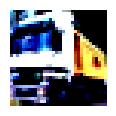

In [7]:
plot_image(train_data[1][0])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
gen_optim = optim.AdamW(params=generator.parameters(), lr=1e-3, weight_decay=1e-4)
dis_optim = optim.AdamW(params=discriminator.parameters(), lr=5e-4, weight_decay=1e-3)

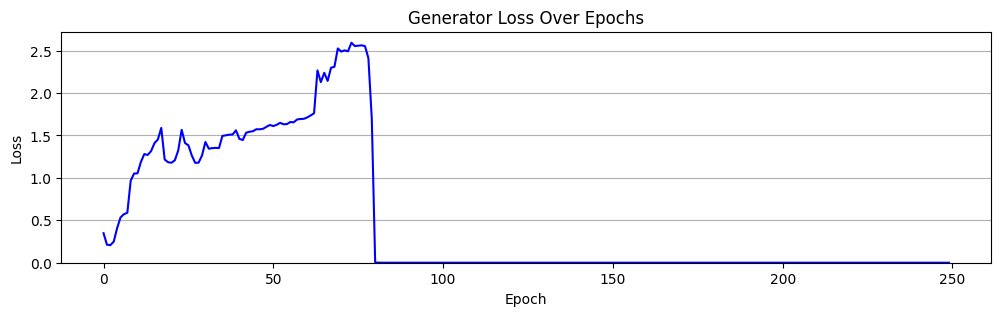

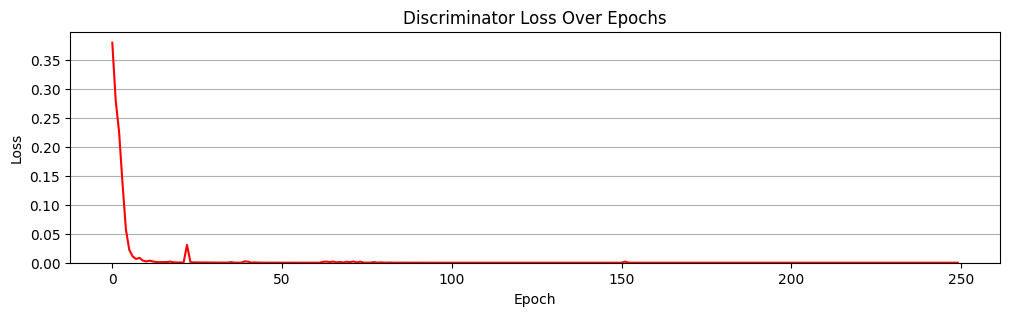

100%|██████████| 250/250 [2:50:26<00:00, 40.90s/it]


In [9]:
gen_losses = []
dis_losses = []

generator.train()
discriminator.train()

num_epochs = 250
for epoch in tqdm(range(num_epochs)):
    
    avg_gen_loss = 0
    avg_dis_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        gen_images = generator(torch.randn((len(images), 3, 32, 32)).to(device))
        pred_cls = discriminator(torch.cat((images, gen_images)).detach())
        
        gt = torch.cat((torch.full((len(images), 1), 0.9), torch.full((len(images), 1), 0.1))).to(device)

        gen_loss = criterion(discriminator(gen_images), torch.ones(len(images), 1).to(device))
        dis_loss = criterion(pred_cls, gt)

        avg_gen_loss += gen_loss.item()
        avg_dis_loss += dis_loss.item()

        gen_optim.zero_grad()
        gen_loss.backward()
        gen_optim.step()

        dis_optim.zero_grad()
        dis_loss.backward()
        dis_optim.step()
    avg_gen_loss = avg_gen_loss / len(train_loader)
    avg_dis_loss = avg_dis_loss / len(train_loader)

    gen_losses.append(avg_gen_loss)
    dis_losses.append(avg_dis_loss)

    clear_output(wait=True)

    plt.figure(figsize=(12, 3))
    plt.title('Generator Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(which='both', axis='y')
    plt.plot(gen_losses, linestyle='-', color='b', label='Generator')
    plt.gca().set_ylim(bottom=0)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.title('Discriminator Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(which='both', axis='y')
    plt.plot(dis_losses, linestyle='-', color='r', label='Discriminator')
    plt.gca().set_ylim(bottom=0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.064664..2.9515061].


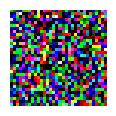

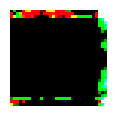

In [18]:
with torch.no_grad():
    test_image = torch.randn((1, 3, 32, 32)).to(device)
    plot_image(test_image[0].cpu())
    generated = (generator(test_image) + 1) / 2
    plot_image(generated[0].cpu())